In [17]:
from queue import Queue
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import array, dstack
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, LayerNormalization, Dense, Attention, MultiHeadAttention, Lambda
from tensorflow.keras.models import Model
# import pygame
import sys
import os
#pygame.init()
# engine = pyttsx3.init() # object creation
SERIAL_PORT = '/dev/cu.DATN'
# be sure to set this to the same rate used on the Arduino
SERIAL_RATE = 38400
test_counter = 240
queue_size = 240
verbose, epochs, batch_size = 1, 40, 300
dataset_path = "./datatrain/"
trainx_file = "./datatrain/trainx.txt"
trainy_file = "./datatrain/trainy.txt"
testx_file = "./datatrain/testx.txt"
testy_file = "./datatrain/testy.txt"
config_file = "./datatrain/config.txt"
enlarged_dataset_path = "./datatrain/model/"


# screen_width = 800
# screen_height = 600
# screen = pygame.display.set_mode((screen_width, screen_height))
# pygame.display.set_caption("Real-time Display")

# Set up fonts
#font = pygame.font.Font(None, 36)
#WHITE = (255, 255, 255)
""" RATE"""
#rate = engine.getProperty('rate')   # getting details of current speaking rate
# engine.setProperty('rate', 125)     # setting up new voice rate
"""VOLUME"""
#volume = engine.getProperty('volume')   #getting to know current volume level (min=0 and max=1)
#print (volume)                          #printing current volume level
# engine.setProperty('volume',1.0)    # setting up volume level  between 0 and 1

"""VOICE"""
#voices = engine.getProperty('voices')       #getting details of current voice
#engine.setProperty('voice', voices[0].id)  #changing index, changes voices. o for male
# engine.setProperty('voice', engine.getProperty('voices')[1].id)   #changing index, changes voices. 1 for female

# def textToSpeech(text):
#     engine.say(text)
#     engine.runAndWait()
#     engine.stop()
    

def readConfig():
    with open('./datatrain/config.txt', 'r',encoding='utf-8') as file:
        # Initialize an empty 2D array
        config = []

        # Iterate over each line in the file
        for line in file:
            # Split the line into individual words
            words = line.strip()

            # Append the words to the 2D array
            config.append(words)
        return config

def readdata(trainx_file, trainy_file, testx_file, testy_file):
    trainx_data =[]
    trainy_data =[]
    testx_data =[]
    testy_data =[]
    with open(trainx_file, 'r') as trainx, open(trainy_file, 'r') as trainy, open(testx_file, 'r') as testx, open(testy_file, 'r') as testy  :
        trainy_data = extract_y(trainy)
        testy_data = extract_y(testy)
        
        trainx_data = extract_data(trainx)
        testx_data = extract_data(testx)

    trainx_data = np.vstack(trainx_data)
    testx_data = np.vstack(testx_data)
    trainy_data = to_categorical(trainy_data)
    testy_data = to_categorical(testy_data)
    return trainx_data, trainy_data, testx_data, testy_data

def extract_data(file):
    data = []
    while True:
            try:
                x1 = []
                x2 = []
                x3 = []
                x4 = []
                x5 = []
                x6 = []
                x7 = []
                line = next(file).strip().split()
                if len(line) >= 1680:
                    for i in range(240):
                        x1.append(float(line[i]))
                        x2.append(float(line[i + 240]))
                        x3.append(float(line[i + 480]))
                        x4.append(float(line[i + 720]))
                        x5.append(float(line[i + 960]))
                        x6.append(float(line[i + 1200]))
                        x7.append(float(line[i + 1440]))
                else:
                    print("Error train data.")
                x1 = array(x1)
                x2 = array(x2)
                x3 = array(x3)
                x4 = array(x4)
                x5 = array(x5)
                x6 = array(x6)
                x7 = array(x7)
                line_dataset = dstack([x1, x2, x3, x4, x5, x6, x7]) 
                line_dataset = line_dataset.reshape(1,240,7)
                data.append(line_dataset)
            except StopIteration:
                break
    return data

def extract_y(file):
    y = []
    for line in file:
        y.append(line)
    y = array(y)
    data = np.vstack(y)
    data.reshape(1,len(y))
    return data


In [18]:
def positional_encoding(length, depth):
    depth = int(depth)
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)                # (1, depth)
    angle_rads = positions * angle_rates             # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class AddPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        _, seq_len, d_model = input_shape
        self.pos_encoding = positional_encoding(seq_len, d_model)

    def call(self, inputs):
        # Ensure positional encoding has the same shape as the input
        return inputs + self.pos_encoding[:tf.shape(inputs)[1], :tf.shape(inputs)[2]]

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        return config

In [19]:
def read_enlarged_data():
    data = []
    filenames = []
    for filename in os.listdir(enlarged_dataset_path):
        filenames.append(filename.split('.')[0])
        filepath = os.path.join(enlarged_dataset_path, filename)
        if os.path.isfile(filepath):
            with open(filepath, 'r') as file:
                train_data = np.vstack(extract_data(file))
                data.append(train_data)
    return data, filenames

def create_model(timesteps, features, num_classes, name = "original_model"):
    # define model
    model = Sequential(name=name)
    model.add(LSTM(units = 128, input_shape = (timesteps, features)))
    model.add(Dropout(0.5)) 
    model.add(Flatten())
    model.add(Dense(units = 64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# def create_model(timesteps, n_features, num_classes, name = "original_model"):
#     inputs = Input(shape=(timesteps, n_features))

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = LSTM(units=128, return_sequences=True)(x)
#     x = LSTM(units=128, return_sequences=True)(x)

#     x = AddPositionalEncoding()(x)

#     # MultiHeadAttention layer
#     attn_output = MultiHeadAttention(num_heads=4, key_dim=128)(x, x, x)
#     x = LayerNormalization()(attn_output + x)

#     x = Dense(units=128, activation='relu')(x)

#     # Global Attention layer
#     attn = Attention()([x, x])
#     x = LayerNormalization()(attn + x)

#     # Global average pooling to reduce sequence dimension
#     x = tf.keras.layers.GlobalAveragePooling1D()(x)

#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs=inputs, outputs=outputs, name=name)
    
#     return model

def evaluate_model(model, testX, testy,  class_names):
    print(f"Evaluate model {model.name}")

    y_pred = model.predict(testX)
    y_pred = np.argmax(y_pred, axis=1)

    y_true = np.argmax(testy, axis=1)

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(xticks_rotation=60, ax=ax)
    plt.show()
    
def plot_val_loss(models, history):
    for model, h in zip(models, history):
        plt.plot(h.history['val_loss'], label=model.name)
    plt.title('model validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

Epoch 1/40
2/2 [==============================] - 8s 3s/step - loss: 3.0376 - accuracy: 0.0638 - val_loss: 2.7572 - val_accuracy: 0.0102
Epoch 2/40
2/2 [==============================] - 4s 2s/step - loss: 2.8544 - accuracy: 0.0944 - val_loss: 2.7508 - val_accuracy: 0.0816
Epoch 3/40
2/2 [==============================] - 4s 2s/step - loss: 2.7490 - accuracy: 0.1505 - val_loss: 2.7561 - val_accuracy: 0.1224
Epoch 4/40
2/2 [==============================] - 5s 2s/step - loss: 2.6481 - accuracy: 0.1709 - val_loss: 2.7384 - val_accuracy: 0.1327
Epoch 5/40
2/2 [==============================] - 4s 2s/step - loss: 2.5808 - accuracy: 0.2321 - val_loss: 2.7294 - val_accuracy: 0.1327
Epoch 6/40
2/2 [==============================] - 5s 2s/step - loss: 2.5119 - accuracy: 0.2423 - val_loss: 2.7194 - val_accuracy: 0.1429
Epoch 7/40
2/2 [==============================] - 5s 2s/step - loss: 2.4763 - accuracy: 0.2219 - val_loss: 2.7214 - val_accuracy: 0.1429
Epoch 8/40
2/2 [=========================

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 9s 2s/step - loss: 2.7017 - accuracy: 0.0880 - val_loss: 2.6198 - val_accuracy: 0.1786
Epoch 2/40
3/3 [==============================] - 7s 2s/step - loss: 2.5766 - accuracy: 0.1862 - val_loss: 2.5374 - val_accuracy: 0.1837
Epoch 3/40
3/3 [==============================] - 7s 2s/step - loss: 2.4510 - accuracy: 0.2857 - val_loss: 2.4359 - val_accuracy: 0.2092
Epoch 4/40
3/3 [==============================] - 7s 2s/step - loss: 2.3008 - accuracy: 0.3151 - val_loss: 2.3101 - val_accuracy: 0.1684
Epoch 5/40
3/3 [==============================] - 7s 2s/step - loss: 2.1636 - accuracy: 0.3163 - val_loss: 2.2408 - val_accuracy: 0.1684
Epoch 6/40
3/3 [==============================] - 7s 2s/step - loss: 2.0399 - accuracy: 0.3138 - val_loss: 2.2517 - val_accuracy: 0.1684
Epoch 7/40
3/3 [==============================] - 7s 2s/step - loss: 1.8846 - accuracy: 0.3890 - val_loss: 2.2748 - val_accuracy: 0.2296


c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 9s 2s/step - loss: 2.6900 - accuracy: 0.1046 - val_loss: 2.4892 - val_accuracy: 0.3061
Epoch 2/40
3/3 [==============================] - 7s 2s/step - loss: 2.5203 - accuracy: 0.2270 - val_loss: 2.2958 - val_accuracy: 0.3061
Epoch 3/40
3/3 [==============================] - 7s 2s/step - loss: 2.3487 - accuracy: 0.2487 - val_loss: 2.0663 - val_accuracy: 0.3112
Epoch 4/40
3/3 [==============================] - 7s 2s/step - loss: 2.1649 - accuracy: 0.2768 - val_loss: 1.8358 - val_accuracy: 0.3265
Epoch 5/40
3/3 [==============================] - 7s 2s/step - loss: 2.0038 - accuracy: 0.2908 - val_loss: 1.7207 - val_accuracy: 0.3265
Epoch 6/40
3/3 [==============================] - 7s 2s/step - loss: 1.8610 - accuracy: 0.3036 - val_loss: 1.6979 - val_accuracy: 0.2806
Epoch 7/40
3/3 [==============================] - 7s 2s/step - loss: 1.7319 - accuracy: 0.3508 - val_loss: 1.7305 - val_accuracy: 0.2602
Epoch 8/40
3/3 [=========================

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 9s 2s/step - loss: 2.7007 - accuracy: 0.0842 - val_loss: 2.6419 - val_accuracy: 0.2398
Epoch 2/40
3/3 [==============================] - 7s 2s/step - loss: 2.5731 - accuracy: 0.1722 - val_loss: 2.5502 - val_accuracy: 0.2704
Epoch 3/40
3/3 [==============================] - 7s 2s/step - loss: 2.4229 - accuracy: 0.3036 - val_loss: 2.4201 - val_accuracy: 0.2704
Epoch 4/40
3/3 [==============================] - 7s 2s/step - loss: 2.2776 - accuracy: 0.3125 - val_loss: 2.2769 - val_accuracy: 0.2857
Epoch 5/40
3/3 [==============================] - 6s 2s/step - loss: 2.1167 - accuracy: 0.3776 - val_loss: 2.1683 - val_accuracy: 0.2653
Epoch 6/40
3/3 [==============================] - 6s 2s/step - loss: 1.9652 - accuracy: 0.3954 - val_loss: 2.1042 - val_accuracy: 0.2500
Epoch 7/40
3/3 [==============================] - 7s 2s/step - loss: 1.8584 - accuracy: 0.4311 - val_loss: 2.1362 - val_accuracy: 0.2143
Epoch 8/40
3/3 [=========================

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 9s 2s/step - loss: 2.6753 - accuracy: 0.0957 - val_loss: 2.6090 - val_accuracy: 0.0357
Epoch 2/40
3/3 [==============================] - 6s 2s/step - loss: 2.5449 - accuracy: 0.1862 - val_loss: 2.5047 - val_accuracy: 0.0816
Epoch 3/40
3/3 [==============================] - 6s 2s/step - loss: 2.4219 - accuracy: 0.2474 - val_loss: 2.3809 - val_accuracy: 0.0867
Epoch 4/40
3/3 [==============================] - 6s 2s/step - loss: 2.2718 - accuracy: 0.3074 - val_loss: 2.2401 - val_accuracy: 0.1786
Epoch 5/40
3/3 [==============================] - 6s 2s/step - loss: 2.1319 - accuracy: 0.3214 - val_loss: 2.1272 - val_accuracy: 0.2245
Epoch 6/40
3/3 [==============================] - 6s 2s/step - loss: 2.0134 - accuracy: 0.3342 - val_loss: 2.0548 - val_accuracy: 0.2449
Epoch 7/40
3/3 [==============================] - 6s 2s/step - loss: 1.8868 - accuracy: 0.3992 - val_loss: 1.9953 - val_accuracy: 0.2602
Epoch 8/40
3/3 [=========================

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 8s 2s/step - loss: 2.6418 - accuracy: 0.1722 - val_loss: 2.5348 - val_accuracy: 0.3316
Epoch 2/40
3/3 [==============================] - 6s 2s/step - loss: 2.4826 - accuracy: 0.3367 - val_loss: 2.3785 - val_accuracy: 0.3929
Epoch 3/40
3/3 [==============================] - 6s 2s/step - loss: 2.3016 - accuracy: 0.4439 - val_loss: 2.1580 - val_accuracy: 0.3980
Epoch 4/40
3/3 [==============================] - 6s 2s/step - loss: 2.0805 - accuracy: 0.4643 - val_loss: 1.9022 - val_accuracy: 0.3929
Epoch 5/40
3/3 [==============================] - 6s 2s/step - loss: 1.8488 - accuracy: 0.4974 - val_loss: 1.7324 - val_accuracy: 0.3622
Epoch 6/40
3/3 [==============================] - 6s 2s/step - loss: 1.6560 - accuracy: 0.4962 - val_loss: 1.6417 - val_accuracy: 0.3367
Epoch 7/40
3/3 [==============================] - 6s 2s/step - loss: 1.4795 - accuracy: 0.5536 - val_loss: 1.5347 - val_accuracy: 0.3520
Epoch 8/40
3/3 [=========================

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 8s 2s/step - loss: 2.6934 - accuracy: 0.0829 - val_loss: 2.6351 - val_accuracy: 0.1173
Epoch 2/40
3/3 [==============================] - 6s 2s/step - loss: 2.5674 - accuracy: 0.2321 - val_loss: 2.5374 - val_accuracy: 0.1888
Epoch 3/40
3/3 [==============================] - 6s 2s/step - loss: 2.4356 - accuracy: 0.3278 - val_loss: 2.4234 - val_accuracy: 0.1735
Epoch 4/40
3/3 [==============================] - 6s 2s/step - loss: 2.2980 - accuracy: 0.3482 - val_loss: 2.3181 - val_accuracy: 0.1582
Epoch 5/40
3/3 [==============================] - 6s 2s/step - loss: 2.1384 - accuracy: 0.3253 - val_loss: 2.2181 - val_accuracy: 0.1531
Epoch 6/40
3/3 [==============================] - 6s 2s/step - loss: 2.0353 - accuracy: 0.3253 - val_loss: 2.1613 - val_accuracy: 0.1531
Epoch 7/40
3/3 [==============================] - 6s 2s/step - loss: 1.9149 - accuracy: 0.3622 - val_loss: 2.1460 - val_accuracy: 0.2041
Epoch 8/40
3/3 [=========================

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 9s 2s/step - loss: 2.6700 - accuracy: 0.1033 - val_loss: 2.6083 - val_accuracy: 0.1480
Epoch 2/40
3/3 [==============================] - 6s 2s/step - loss: 2.5527 - accuracy: 0.2704 - val_loss: 2.4946 - val_accuracy: 0.2653
Epoch 3/40
3/3 [==============================] - 6s 2s/step - loss: 2.4262 - accuracy: 0.3380 - val_loss: 2.3588 - val_accuracy: 0.2959
Epoch 4/40
3/3 [==============================] - 6s 2s/step - loss: 2.2694 - accuracy: 0.3852 - val_loss: 2.1689 - val_accuracy: 0.3112
Epoch 5/40
3/3 [==============================] - 6s 2s/step - loss: 2.0925 - accuracy: 0.3571 - val_loss: 1.9653 - val_accuracy: 0.3214
Epoch 6/40
3/3 [==============================] - 6s 2s/step - loss: 1.9334 - accuracy: 0.3253 - val_loss: 1.8401 - val_accuracy: 0.3469
Epoch 7/40
3/3 [==============================] - 6s 2s/step - loss: 1.8227 - accuracy: 0.3801 - val_loss: 1.7978 - val_accuracy: 0.3163
Epoch 8/40
3/3 [=========================

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 8s 2s/step - loss: 2.7110 - accuracy: 0.0791 - val_loss: 2.5611 - val_accuracy: 0.2092
Epoch 2/40
3/3 [==============================] - 6s 2s/step - loss: 2.5582 - accuracy: 0.1582 - val_loss: 2.4014 - val_accuracy: 0.2296
Epoch 3/40
3/3 [==============================] - 6s 2s/step - loss: 2.3937 - accuracy: 0.2321 - val_loss: 2.2271 - val_accuracy: 0.1684
Epoch 4/40
3/3 [==============================] - 6s 2s/step - loss: 2.2292 - accuracy: 0.2755 - val_loss: 2.1040 - val_accuracy: 0.1531
Epoch 5/40
3/3 [==============================] - 6s 2s/step - loss: 2.1189 - accuracy: 0.2972 - val_loss: 2.0236 - val_accuracy: 0.1582
Epoch 6/40
3/3 [==============================] - 6s 2s/step - loss: 1.9975 - accuracy: 0.3520 - val_loss: 1.9243 - val_accuracy: 0.2041
Epoch 7/40
3/3 [==============================] - 6s 2s/step - loss: 1.8943 - accuracy: 0.4133 - val_loss: 1.8054 - val_accuracy: 0.2194
Epoch 8/40
3/3 [=========================

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/40
3/3 [==============================] - 8s 2s/step - loss: 2.7059 - accuracy: 0.1020 - val_loss: 2.6908 - val_accuracy: 0.1122
Epoch 2/40
3/3 [==============================] - 6s 2s/step - loss: 2.6035 - accuracy: 0.2015 - val_loss: 2.6272 - val_accuracy: 0.1735
Epoch 3/40
3/3 [==============================] - 6s 2s/step - loss: 2.5220 - accuracy: 0.2666 - val_loss: 2.5579 - val_accuracy: 0.1837
Epoch 4/40
3/3 [==============================] - 6s 2s/step - loss: 2.4094 - accuracy: 0.3036 - val_loss: 2.4632 - val_accuracy: 0.2041
Epoch 5/40
3/3 [==============================] - 6s 2s/step - loss: 2.2964 - accuracy: 0.3036 - val_loss: 2.3460 - val_accuracy: 0.2194
Epoch 6/40
3/3 [==============================] - 6s 2s/step - loss: 2.1655 - accuracy: 0.3125 - val_loss: 2.2437 - val_accuracy: 0.2347
Epoch 7/40
3/3 [==============================] - 6s 2s/step - loss: 2.0481 - accuracy: 0.3431 - val_loss: 2.1734 - val_accuracy: 0.2755
Epoch 8/40
3/3 [=========================

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


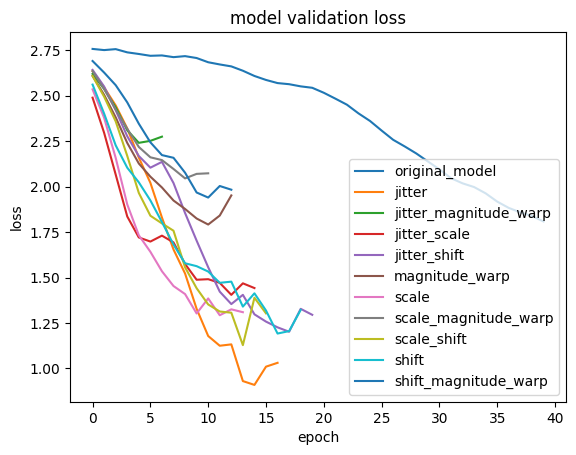

Evaluate model original_model
12/12 [==============================] - 2s 126ms/step
              precision    recall  f1-score   support

         Giữ       0.00      0.00      0.00        40
    Tạm Biệt       0.01      0.03      0.01        40
     Tốt lắm       0.00      0.00      0.00        30
         Tôi       0.00      0.00      0.00        10
  Không biết       0.00      0.00      0.00        10
                   0.56      0.17      0.26        30
         Bạn       0.00      0.00      0.00        10
       Đi bộ       0.00      0.00      0.00        20
  Xung quanh       0.51      0.70      0.59        40
    Đùa thôi       0.00      0.00      0.00        20
     Tại đây       0.59      0.72      0.65        40
    Xin chào       0.30      0.90      0.45        20
Tên là Chánh       0.35      0.85      0.50        20
     Rất vui       0.07      0.05      0.06        20
         Gặp       0.00      0.00      0.00        20

    accuracy                           0.27      

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

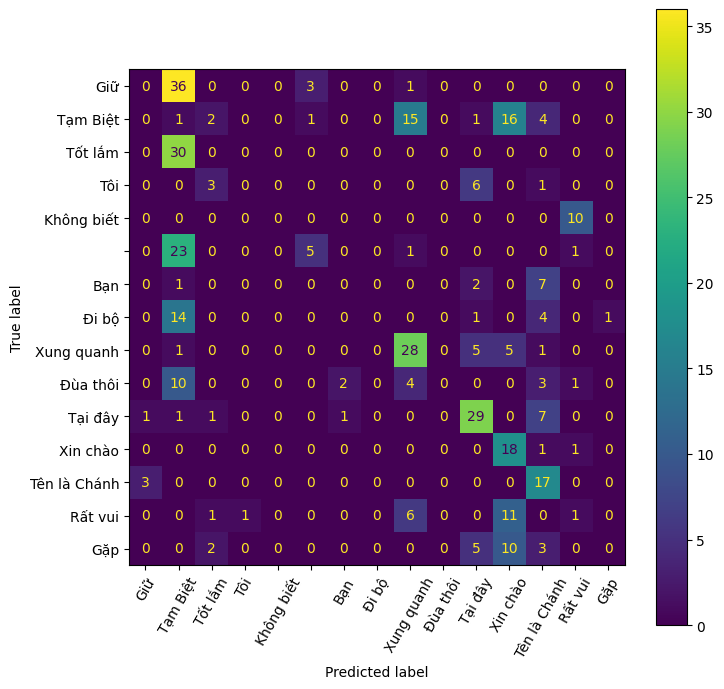

Evaluate model jitter
12/12 [==============================] - 2s 127ms/step
              precision    recall  f1-score   support

         Giữ       0.98      1.00      0.99        40
    Tạm Biệt       0.82      0.35      0.49        40
     Tốt lắm       1.00      0.97      0.98        30
         Tôi       0.00      0.00      0.00        10
  Không biết       1.00      1.00      1.00        10
                   0.83      0.80      0.81        30
         Bạn       1.00      0.40      0.57        10
       Đi bộ       0.83      0.95      0.88        20
  Xung quanh       0.95      0.95      0.95        40
    Đùa thôi       1.00      0.40      0.57        20
     Tại đây       0.91      1.00      0.95        40
    Xin chào       0.77      1.00      0.87        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       0.48      1.00      0.65        20
         Gặp       0.54      1.00      0.70        20

    accuracy                           0.83       370
   

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

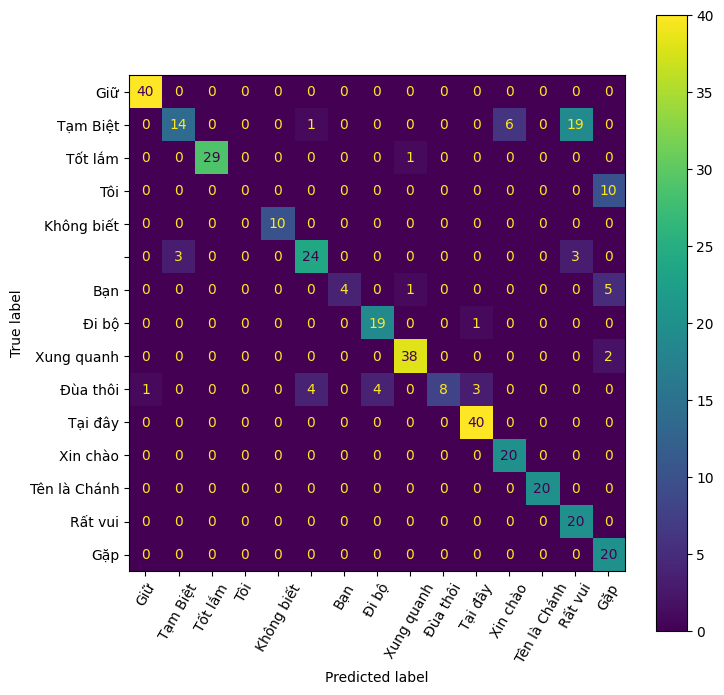

Evaluate model jitter_magnitude_warp
12/12 [==============================] - 2s 128ms/step
              precision    recall  f1-score   support

         Giữ       0.40      0.88      0.55        40
    Tạm Biệt       0.00      0.00      0.00        40
     Tốt lắm       0.00      0.00      0.00        30
         Tôi       0.00      0.00      0.00        10
  Không biết       0.70      0.70      0.70        10
                   0.89      0.57      0.69        30
         Bạn       0.00      0.00      0.00        10
       Đi bộ       0.00      0.00      0.00        20
  Xung quanh       0.35      1.00      0.52        40
    Đùa thôi       0.00      0.00      0.00        20
     Tại đây       0.93      0.65      0.76        40
    Xin chào       1.00      0.60      0.75        20
Tên là Chánh       1.00      0.90      0.95        20
     Rất vui       0.25      0.95      0.39        20
         Gặp       0.33      0.05      0.09        20

    accuracy                           0.4

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

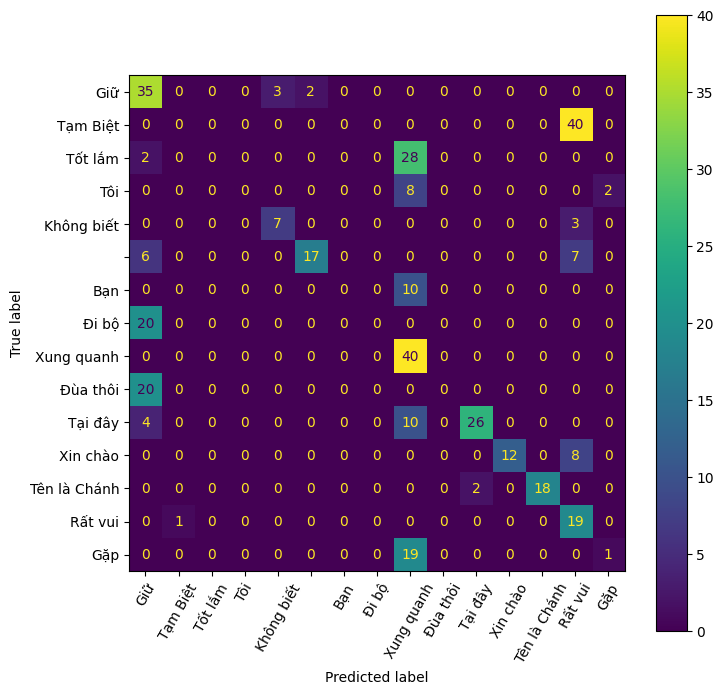

Evaluate model jitter_scale
12/12 [==============================] - 2s 130ms/step
              precision    recall  f1-score   support

         Giữ       0.93      0.97      0.95        40
    Tạm Biệt       0.80      0.20      0.32        40
     Tốt lắm       0.85      0.97      0.91        30
         Tôi       0.00      0.00      0.00        10
  Không biết       1.00      1.00      1.00        10
                   0.93      0.83      0.88        30
         Bạn       0.00      0.00      0.00        10
       Đi bộ       1.00      0.85      0.92        20
  Xung quanh       0.54      1.00      0.70        40
    Đùa thôi       0.88      0.75      0.81        20
     Tại đây       0.97      0.90      0.94        40
    Xin chào       1.00      0.85      0.92        20
Tên là Chánh       0.74      1.00      0.85        20
     Rất vui       0.35      1.00      0.52        20
         Gặp       0.00      0.00      0.00        20

    accuracy                           0.75       3

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

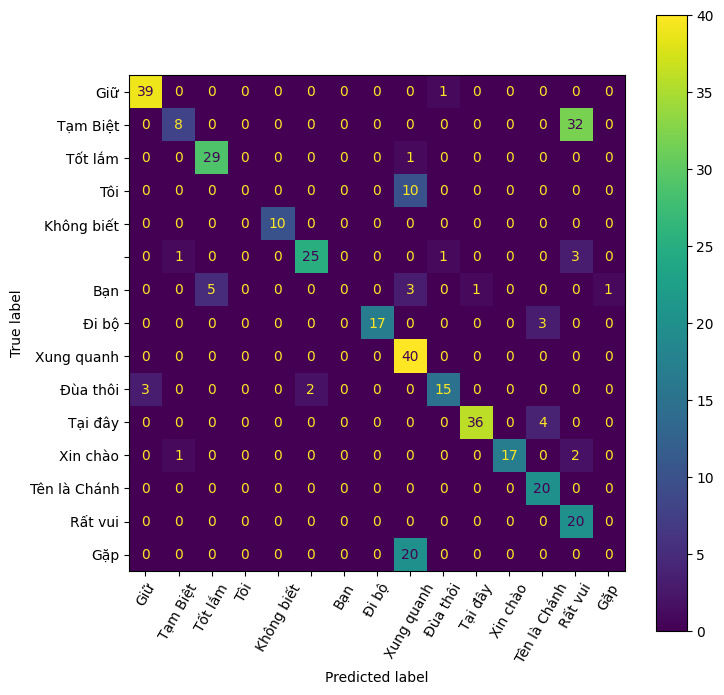

Evaluate model jitter_shift
12/12 [==============================] - 2s 134ms/step
              precision    recall  f1-score   support

         Giữ       0.90      0.90      0.90        40
    Tạm Biệt       1.00      0.55      0.71        40
     Tốt lắm       1.00      0.40      0.57        30
         Tôi       1.00      0.80      0.89        10
  Không biết       1.00      1.00      1.00        10
                   0.96      0.83      0.89        30
         Bạn       0.00      0.00      0.00        10
       Đi bộ       0.36      0.80      0.50        20
  Xung quanh       0.52      0.65      0.58        40
    Đùa thôi       0.00      0.00      0.00        20
     Tại đây       1.00      0.97      0.99        40
    Xin chào       1.00      0.95      0.97        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       0.50      1.00      0.67        20
         Gặp       0.40      0.80      0.53        20

    accuracy                           0.73       3

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

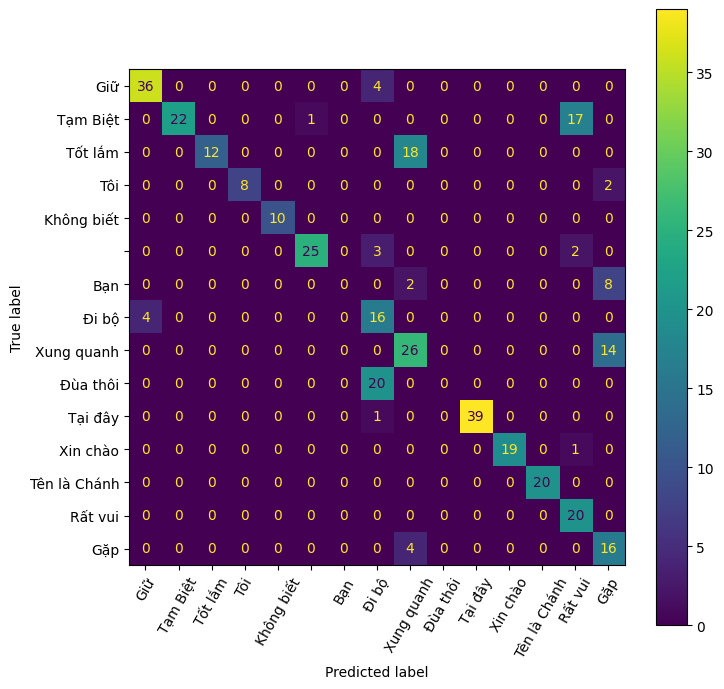

Evaluate model magnitude_warp
12/12 [==============================] - 2s 139ms/step
              precision    recall  f1-score   support

         Giữ       0.55      1.00      0.71        40
    Tạm Biệt       0.00      0.00      0.00        40
     Tốt lắm       0.93      0.90      0.92        30
         Tôi       0.00      0.00      0.00        10
  Không biết       1.00      1.00      1.00        10
                   0.46      0.77      0.57        30
         Bạn       1.00      0.60      0.75        10
       Đi bộ       0.00      0.00      0.00        20
  Xung quanh       0.97      0.70      0.81        40
    Đùa thôi       0.00      0.00      0.00        20
     Tại đây       0.73      1.00      0.84        40
    Xin chào       1.00      1.00      1.00        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       0.57      1.00      0.73        20
         Gặp       0.47      1.00      0.63        20

    accuracy                           0.69      

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

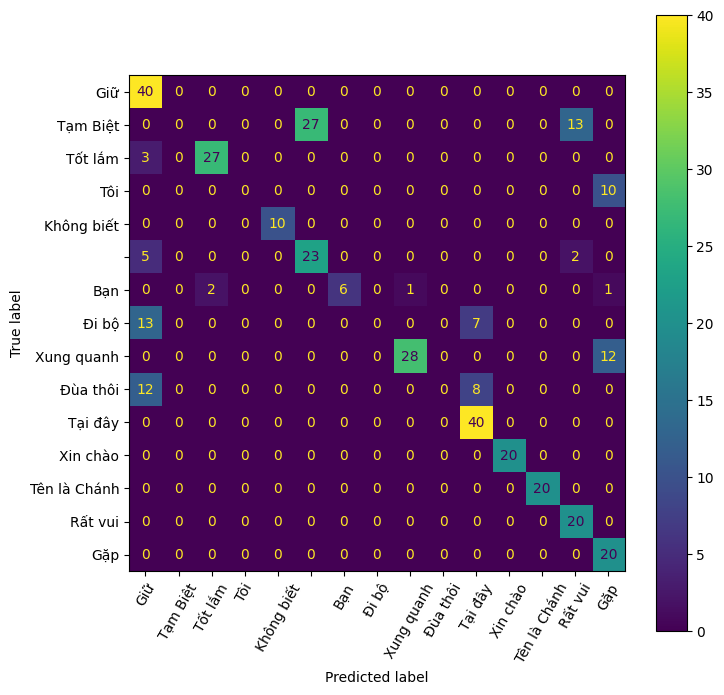

Evaluate model scale
12/12 [==============================] - 2s 137ms/step
              precision    recall  f1-score   support

         Giữ       0.68      0.85      0.76        40
    Tạm Biệt       0.80      0.70      0.75        40
     Tốt lắm       0.00      0.00      0.00        30
         Tôi       0.00      0.00      0.00        10
  Không biết       1.00      1.00      1.00        10
                   0.56      0.83      0.67        30
         Bạn       0.00      0.00      0.00        10
       Đi bộ       0.55      0.30      0.39        20
  Xung quanh       0.50      0.78      0.61        40
    Đùa thôi       0.00      0.00      0.00        20
     Tại đây       1.00      0.82      0.90        40
    Xin chào       0.83      1.00      0.91        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       0.72      0.90      0.80        20
         Gặp       0.36      1.00      0.53        20

    accuracy                           0.66       370
   m

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

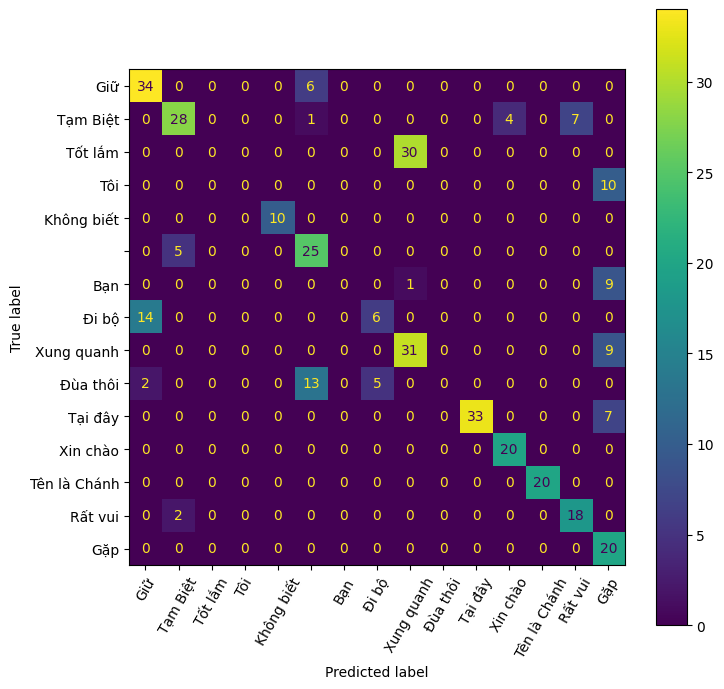

Evaluate model scale_magnitude_warp
12/12 [==============================] - 2s 150ms/step
              precision    recall  f1-score   support

         Giữ       0.45      0.88      0.60        40
    Tạm Biệt       0.17      0.05      0.08        40
     Tốt lắm       0.96      0.80      0.87        30
         Tôi       0.00      0.00      0.00        10
  Không biết       0.00      0.00      0.00        10
                   0.72      0.60      0.65        30
         Bạn       0.00      0.00      0.00        10
       Đi bộ       1.00      0.05      0.10        20
  Xung quanh       0.83      0.72      0.77        40
    Đùa thôi       0.00      0.00      0.00        20
     Tại đây       0.81      0.97      0.89        40
    Xin chào       0.80      1.00      0.89        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       0.34      1.00      0.51        20
         Gặp       0.34      0.75      0.47        20

    accuracy                           0.60

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

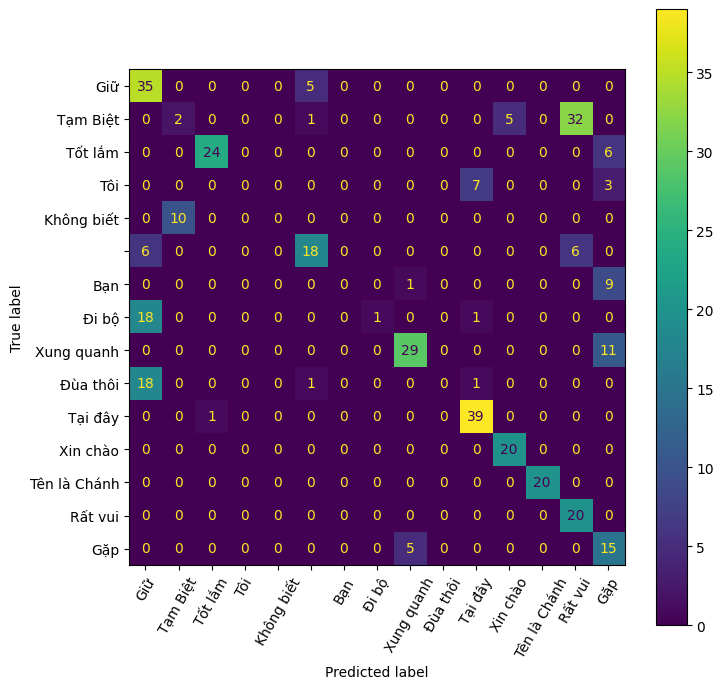

Evaluate model scale_shift
12/12 [==============================] - 2s 140ms/step
              precision    recall  f1-score   support

         Giữ       0.40      1.00      0.57        40
    Tạm Biệt       0.97      0.85      0.91        40
     Tốt lắm       1.00      0.27      0.42        30
         Tôi       0.00      0.00      0.00        10
  Không biết       1.00      0.90      0.95        10
                   0.81      0.87      0.84        30
         Bạn       0.00      0.00      0.00        10
       Đi bộ       0.00      0.00      0.00        20
  Xung quanh       1.00      0.57      0.73        40
    Đùa thôi       0.00      0.00      0.00        20
     Tại đây       1.00      1.00      1.00        40
    Xin chào       0.87      1.00      0.93        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       0.91      1.00      0.95        20
         Gặp       0.34      1.00      0.51        20

    accuracy                           0.70       37

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

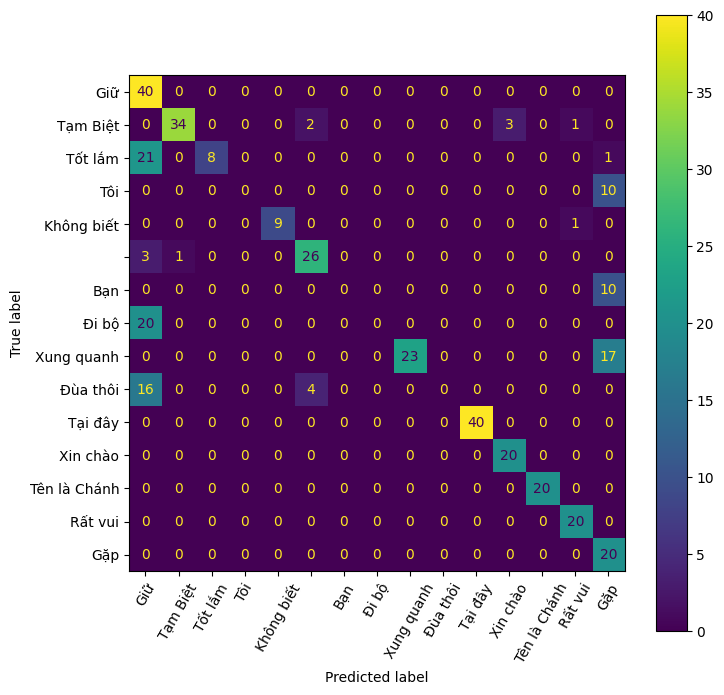

Evaluate model shift
12/12 [==============================] - 2s 148ms/step
              precision    recall  f1-score   support

         Giữ       0.88      0.93      0.90        40
    Tạm Biệt       0.67      0.97      0.80        40
     Tốt lắm       1.00      0.20      0.33        30
         Tôi       0.00      0.00      0.00        10
  Không biết       1.00      1.00      1.00        10
                   0.84      0.87      0.85        30
         Bạn       0.00      0.00      0.00        10
       Đi bộ       0.80      0.80      0.80        20
  Xung quanh       0.55      0.75      0.63        40
    Đùa thôi       0.75      0.60      0.67        20
     Tại đây       0.81      0.97      0.89        40
    Xin chào       1.00      0.70      0.82        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       0.70      0.35      0.47        20
         Gặp       0.50      1.00      0.67        20

    accuracy                           0.75       370
   m

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

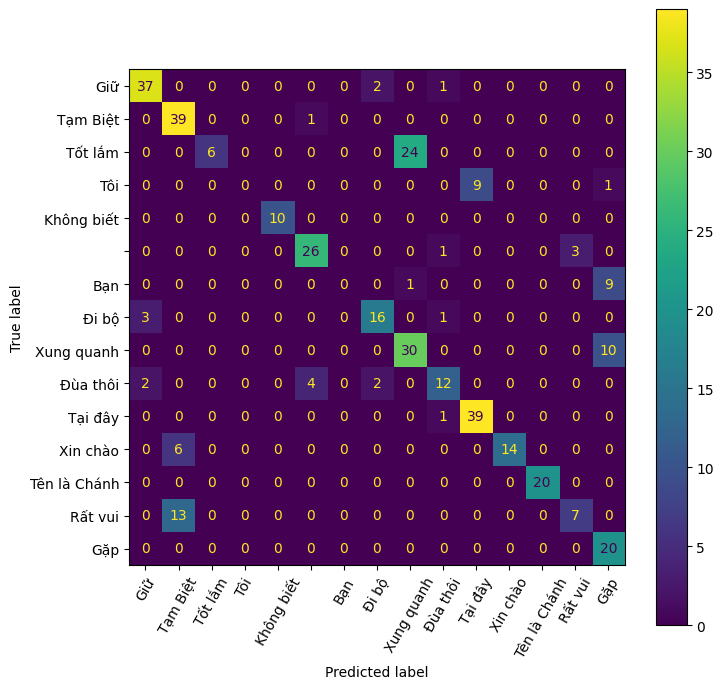

Evaluate model shift_magnitude_warp
12/12 [==============================] - 2s 152ms/step
              precision    recall  f1-score   support

         Giữ       0.46      0.93      0.62        40
    Tạm Biệt       1.00      0.45      0.62        40
     Tốt lắm       0.00      0.00      0.00        30
         Tôi       0.00      0.00      0.00        10
  Không biết       1.00      1.00      1.00        10
                   0.79      0.73      0.76        30
         Bạn       0.71      0.50      0.59        10
       Đi bộ       0.00      0.00      0.00        20
  Xung quanh       0.67      1.00      0.80        40
    Đùa thôi       0.00      0.00      0.00        20
     Tại đây       0.93      0.97      0.95        40
    Xin chào       1.00      0.90      0.95        20
Tên là Chánh       1.00      1.00      1.00        20
     Rất vui       0.43      1.00      0.60        20
         Gặp       0.05      0.10      0.07        20

    accuracy                           0.62

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

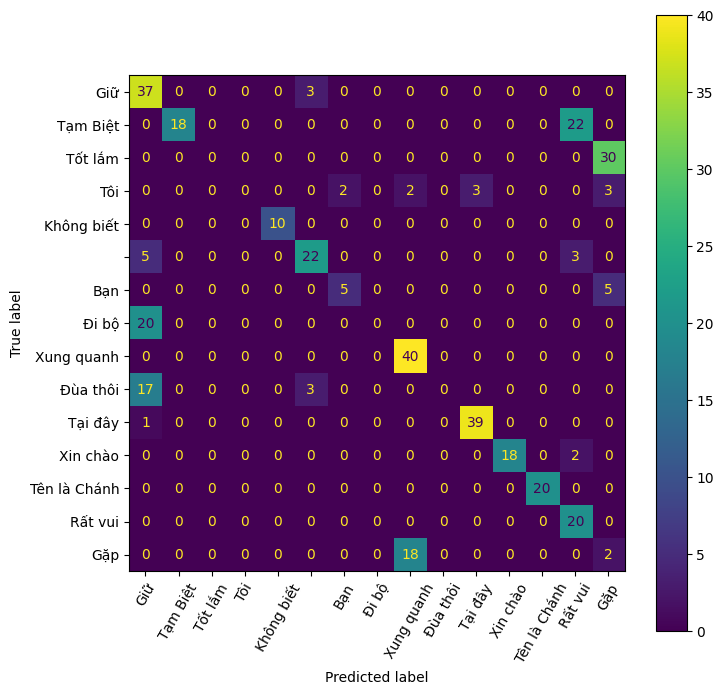

In [20]:
def main():
    trainX, trainy, testX, testy = readdata(trainx_file, trainy_file, testx_file, testy_file)
    class_names = readConfig()
    timesteps, n_features, num_classes = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    
    data_augmentation, techniques = read_enlarged_data()
    models = []
    history = []
    
    scaler = StandardScaler()

    original_model = create_model(timesteps, n_features, num_classes)
    original_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history.append(original_model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
    models.append(original_model)


    for data, technique in zip(data_augmentation, techniques):
        train_x = np.vstack([trainX, data])
        train_y = np.vstack([trainy, trainy])
        train_x = scaler.fit_transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
        model = create_model(timesteps, n_features, num_classes, name=technique)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history.append(model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
        models.append(model)
        model.save(f"./model/{model.name}.h5")
    

    plot_val_loss(models, history)
    
    for model in models:
        testX = scaler.fit_transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
        evaluate_model(model, testX, testy, class_names)


if __name__ == "__main__":
    main()
